# Sensitivity analysis based on the parallel coordinate plot

## Introduction

In this example, we analyse the sensitivity of the output model with respect to its inputs. 
Let $Y=g(\boldsymbol{X})$ be the scalar output of the model $g$ with vector 
input $\boldsymbol{X}$ with dimension $n_x \in \mathbb{N}$. 
Let $a < b$ be two real numbers. 
We consider the event $\{a \leq Y < b\}$. 
We want to compute the sensitivity of that event with respect to each input $X_i$ for $i = 1, ..., n_x$. 

We consider the same model presented in `demo_plot_event.ipynb`.

In this example, we use the parallel coordinate plot. 
The ideas from this example lead two different ways to analyse the sensitivity of the output of a model:
- `demo_plot_event.ipynb`: analyse the sensitivity of the output of a model by conditioning on the output in an interval or defined from a quantile ;
- `demo_plot_conditioning.ipynb`: analyse the sensitivity of the output of a model by conditioning on a sequence of quantiles.

In [28]:
import otsensitivity as ots
import openturns as ot
import openturns.viewer as otv
from matplotlib import pylab as plt

## Python script

The next cell defines the flood model. 

In [29]:
def getFloodingInputDistribution():
    """
    Return the input distribution of the model.

    Return
    ------
    inputDistribution: ot.ComposedDistribution(4)
        The input distribution of the model
    """
    dist_Q = ot.Gumbel(558.0, 1013.0)
    dist_Q = ot.TruncatedDistribution(dist_Q, 0)
    dist_Q.setDescription(["Q"])
    dist_Ks = ot.Normal(30, 7.5)
    dist_Ks = ot.TruncatedDistribution(dist_Ks, 0)
    dist_Ks.setDescription(["Ks"])
    dist_Zv = ot.Uniform(49.0, 51.0)
    dist_Zv.setDescription(["Zv"])
    dist_Zm = ot.Uniform(54.0, 56.0)
    dist_Zm.setDescription(["Zm"])
    inputDistribution = ot.ComposedDistribution([dist_Q, dist_Ks, dist_Zv, dist_Zm])
    return inputDistribution


def getFloodingSample(sampleSize):
    """
    Return a sample from the physical model.

    Parameters
    ----------
    sampleSize: int
        The sample size.

    Return
    ------
    inputSample: ot.Sample(sampleSize, inputDimension)
        The input sample.
    outputSample: ot.Sample(sampleSize, outputDimension)
        The output sample.
    """
    # Workaround for https://github.com/openturns/openturns/pull/2358
    physicalModel = ot.SymbolicFunction(
        ["Q", "Ks", "Zv", "Zm"],
        ["H", "S"],
        "H := (Q / (Ks * 300.0 * sqrt((Zm - Zv) / 5000.0)))^(3.0 / 5.0); S := H + Zv - 58.5",
    )

    inputDistribution = getFloodingInputDistribution()
    inputSample = inputDistribution.getSample(sampleSize)
    outputSample = physicalModel(inputSample)
    return inputSample, outputSample

Then we generate a sample from this model. The sensitivity analysis method that we present in this example only uses a pair of (X, Y) samples.

In [30]:
ot.Log.Show(ot.Log.NONE)

sampleSize = 1000

inputSample, outputSample = getFloodingSample(sampleSize)
inputSample[:5]

,Q,Ks,Zv,Zm
0,1070.595,39.98057,49.42518,54.94832
1,982.837,30.84146,50.55113,54.01101
2,1485.482,27.0666,49.82351,55.41463
3,779.5736,15.22696,50.87765,55.10541
4,1194.863,25.00564,50.54422,54.59592


In [31]:
outputSample[:5]

,H,S
0,1.808957,-7.265859
1,2.310509,-5.638365
2,2.772227,-5.904265
3,2.891557,-4.730792
4,2.809929,-5.145846


Alpha = 0.8
Lower bound = 3.196896428941156
Upper bound = 9.219683742215247


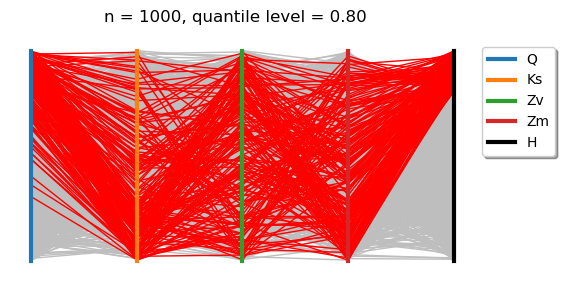

In [32]:
# %%
alphaLevel = 0.8
lowerBound = outputSample.computeQuantilePerComponent(alphaLevel)[0]
upperBound = outputSample.getMax()[0]
print(f"Alpha = {alphaLevel}")
print(f"Lower bound = {lowerBound}")
print(f"Upper bound = {upperBound}")

# We deactivate the default quantile scale.
quantileScale = False
outputIndex = 0  # Consider only the output H
outputMarginalSample = outputSample.getMarginal(outputIndex)
graph = ot.VisualTest.DrawParallelCoordinates(
    inputSample, outputMarginalSample, lowerBound, upperBound, "red", quantileScale
)
inputDescription = inputDistribution.getDescription()
outputDescription = physicalModel.getDescription()
graph.setTitle(f"n = {sampleSize}, quantile level = {alphaLevel:.2f}")
graph.setLegendPosition("bottomright")
view = otv.View(
    graph,
    figure_kw={"figsize": (6.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)

On each axis, the outputs are presented given their ranks. Hence, each vertical line is on the [0,1] interval. This explains why the distribution of the grey lines is uniform on each axis. The selection is done on the $H$ axis, which is the rightmost vertical line in the plot. We see that the largest values are selected. The selection performs a _graphical inversion_: we analyse the distribution of the red lines on each axis, by considering how different it is from the uniform unconditional distribution.

In the previous plot, we see that the distribution on the $Q$ axis is far from uniform: higher values of the input $Q$ leads to large values of the output $H$. The red lines on the $Z_v$ axis are almost uniform distribution in the $[0, 1]$ interval. This shows that the distribution of the output variable $H$ is not sensitive to the distribution of the input variable $Z_v$. 